# 2 — Error Analysis & Training Dynamics

Analisi degli errori di BERTino sul test set, confronto con la baseline, e visualizzazione delle dinamiche di training.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

PROJECT_ROOT = Path("..").resolve()
RESULTS_DIR = PROJECT_ROOT / "results"
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\OrsoPeruzzi\visual_studio_projects\unifi\text-mining-nlp-unifi\amelia-bertino-legal-nlp


## 2.1 — Predizioni su test set

In [2]:
# Carica test set
ds_test = load_dataset("nlp-unibo/AMELIA", split="test")
test_df = ds_test.to_pandas()
test_df["text_len_words"] = test_df["Text"].str.split().str.len()

# Etichette gold
LABEL2ID = {"prem": 0, "conc": 1}
ID2LABEL = {0: "prem", 1: "conc"}
test_df["gold_id"] = test_df["Component"].map(LABEL2ID)

print(f"Test set: {len(test_df)} campioni")
print(test_df["Component"].value_counts())

Test set: 594 campioni
Component
prem    516
conc     78
Name: count, dtype: int64


In [3]:
# Predizioni baseline (TF-IDF + LR)
from amelia_experiment.baseline import load_baseline_pipeline
from amelia_experiment.preprocess import normalize_text

baseline_pipeline = load_baseline_pipeline()
baseline_texts = [normalize_text(t) for t in test_df["Text"]]
test_df["baseline_pred"] = baseline_pipeline.predict(baseline_texts)
test_df["baseline_label"] = test_df["baseline_pred"].map(ID2LABEL)
test_df["baseline_correct"] = test_df["gold_id"] == test_df["baseline_pred"]

print(
    f"Baseline: {test_df['baseline_correct'].sum()}/{len(test_df)} corretti"
    f" ({test_df['baseline_correct'].mean() * 100:.1f}%)"
)

Baseline: 545/594 corretti (91.8%)


In [4]:
# Predizioni BERTino
from amelia_experiment.bertino import load_bertino, predict_texts

model, tokenizer = load_bertino()
bertino_preds = predict_texts(test_df["Text"].tolist(), model=model, tokenizer=tokenizer)

test_df["bertino_pred"] = [p["label_id"] for p in bertino_preds]
test_df["bertino_label"] = [p["label"] for p in bertino_preds]
test_df["bertino_confidence"] = [p["confidence"] for p in bertino_preds]
test_df["bertino_correct"] = test_df["gold_id"] == test_df["bertino_pred"]

print(
    f"BERTino:  {test_df['bertino_correct'].sum()}/{len(test_df)} corretti"
    f" ({test_df['bertino_correct'].mean() * 100:.1f}%)"
)

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 1332.87it/s, Materializing param=pre_classifier.weight]                                  


BERTino:  573/594 corretti (96.5%)


## 2.2 — Analisi degli errori di BERTino

In [5]:
errors_bert = test_df[~test_df["bertino_correct"]].copy()

print(f"Totale errori BERTino: {len(errors_bert)}")
print("\nTipologia errori:")
error_types = errors_bert.groupby(["Component", "bertino_label"]).size().reset_index(name="count")
print(error_types.to_string(index=False))

print("\n--- Errori prem→conc (False Positive per conc) ---")
fp = errors_bert[errors_bert["Component"] == "prem"]
print(f"N={len(fp)}, confidence media: {fp['bertino_confidence'].mean():.3f}")

print("\n--- Errori conc→prem (False Negative per conc) ---")
fn = errors_bert[errors_bert["Component"] == "conc"]
print(f"N={len(fn)}, confidence media: {fn['bertino_confidence'].mean():.3f}")

Totale errori BERTino: 21

Tipologia errori:
Component bertino_label  count
     conc          prem     11
     prem          conc     10

--- Errori prem→conc (False Positive per conc) ---
N=10, confidence media: 0.797

--- Errori conc→prem (False Negative per conc) ---
N=11, confidence media: 0.907


In [6]:
# Mostra i testi degli errori con il testo troncato
print("=== ERRORI DI BERTINO SUL TEST SET ===")
print()
for i, (_, row) in enumerate(errors_bert.iterrows(), 1):
    text_preview = row["Text"][:200] + "..." if len(row["Text"]) > 200 else row["Text"]
    print(
        f"[{i}] Gold: {row['Component']} → Pred: {row['bertino_label']} "
        f"(conf: {row['bertino_confidence']:.3f}, "
        f"len: {row['text_len_words']}w)"
    )
    print(f"    {text_preview}")
    print()

=== ERRORI DI BERTINO SUL TEST SET ===

[1] Gold: conc → Pred: prem (conf: 0.958, len: 21w)
    si osserva che nell'avviso di intimazione è ritualmente indicato il responsabile del procedimento (GA) le cui funzioni sono stabilite dalla legge

[2] Gold: prem → Pred: conc (conf: 0.569, len: 29w)
    Con l'appello la parte eccepisce il difetto di motivazione,l'inesistenza di prove presuntive,il mancato riscontro della posizione soggettiva ed il potere sostitutivo del Primo Giudice nella valutazion...

[3] Gold: prem → Pred: conc (conf: 0.944, len: 12w)
    Preliminarmente è necessario esaminare la questione di inammissibilità dell'appello sollevata dagli appellati

[4] Gold: prem → Pred: conc (conf: 0.902, len: 18w)
    Passando al merito questa commissione ritiene di non poter condividere le argomentazioni poste a sostegno della sentenza impugnata

[5] Gold: prem → Pred: conc (conf: 0.943, len: 20w)
    Il Collegio ritiene pertanto legittimi tutti i recuperi eseguiti dall'Ufficio mentre 

## 2.3 — Confidence analysis

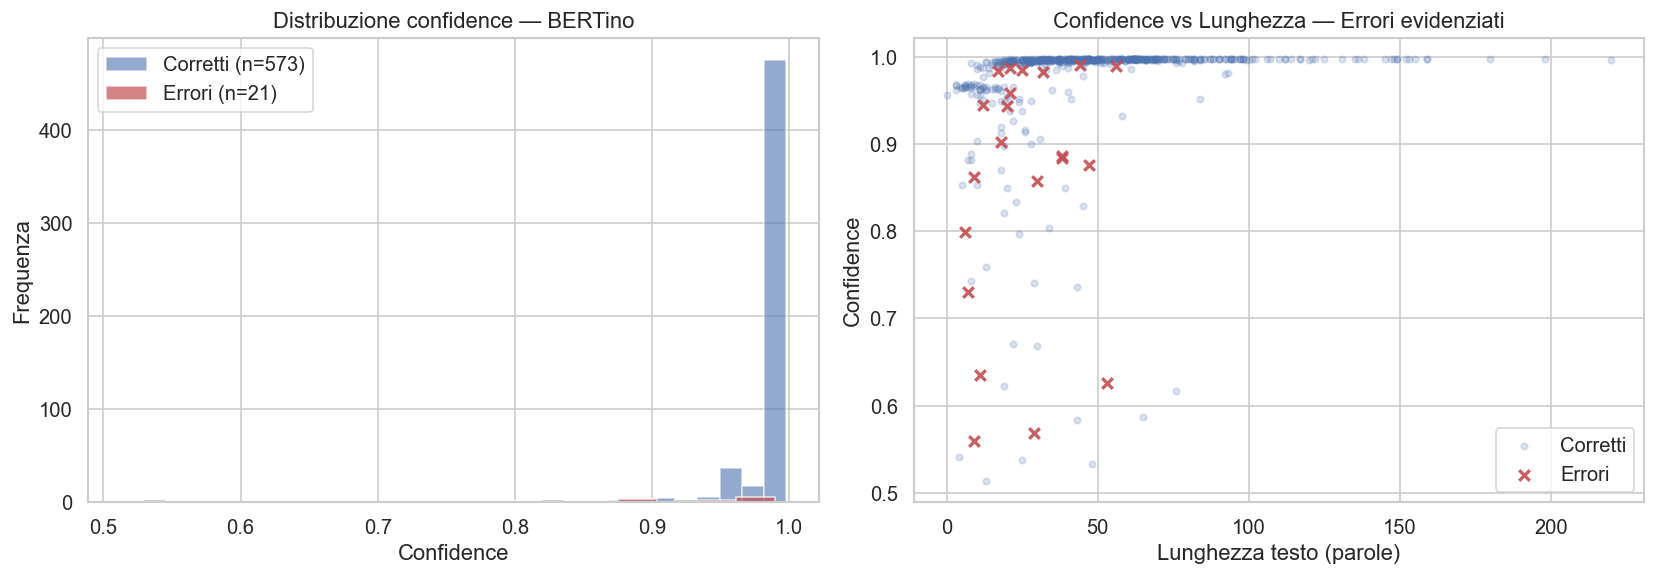

Confidence media — corretti: 0.9786
Confidence media — errori:   0.8549


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuzione confidence corretti vs errori
correct = test_df[test_df["bertino_correct"]]
wrong = test_df[~test_df["bertino_correct"]]

axes[0].hist(
    correct["bertino_confidence"],
    bins=30,
    alpha=0.6,
    label=f"Corretti (n={len(correct)})",
    color="#4C72B0",
    edgecolor="white",
)
axes[0].hist(
    wrong["bertino_confidence"],
    bins=15,
    alpha=0.7,
    label=f"Errori (n={len(wrong)})",
    color="#C44E52",
    edgecolor="white",
)
axes[0].set_xlabel("Confidence")
axes[0].set_ylabel("Frequenza")
axes[0].set_title("Distribuzione confidence — BERTino")
axes[0].legend()

# Confidence vs lunghezza testo (errori evidenziati)
axes[1].scatter(
    correct["text_len_words"],
    correct["bertino_confidence"],
    alpha=0.2,
    s=15,
    color="#4C72B0",
    label="Corretti",
)
axes[1].scatter(
    wrong["text_len_words"],
    wrong["bertino_confidence"],
    alpha=0.9,
    s=40,
    color="#C44E52",
    marker="x",
    linewidths=2,
    label="Errori",
)
axes[1].set_xlabel("Lunghezza testo (parole)")
axes[1].set_ylabel("Confidence")
axes[1].set_title("Confidence vs Lunghezza — Errori evidenziati")
axes[1].legend()

fig.tight_layout()
plt.savefig("../results/plots/confidence_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Confidence media — corretti: {correct['bertino_confidence'].mean():.4f}")
print(f"Confidence media — errori:   {wrong['bertino_confidence'].mean():.4f}")

## 2.4 — Confronto errori: Baseline vs BERTino

In [8]:
# Errori della baseline
errors_base = test_df[~test_df["baseline_correct"]]
errors_bert_idx = set(errors_bert.index)
errors_base_idx = set(errors_base.index)

both_wrong = errors_bert_idx & errors_base_idx
only_bert_wrong = errors_bert_idx - errors_base_idx
only_base_wrong = errors_base_idx - errors_bert_idx

print(f"Errori solo baseline:             {len(only_base_wrong)}")
print(f"Errori solo BERTino:              {len(only_bert_wrong)}")
print(f"Errori in comune:                 {len(both_wrong)}")
print(
    f"\nBaseline sbaglia {len(errors_base_idx)} campioni, BERTino ne sbaglia {len(errors_bert_idx)}."
)
print(f"BERTino corregge {len(only_base_wrong)} errori della baseline ")
print(f"ma ne introduce {len(only_bert_wrong)} nuovi.")

Errori solo baseline:             38
Errori solo BERTino:              10
Errori in comune:                 11

Baseline sbaglia 49 campioni, BERTino ne sbaglia 21.
BERTino corregge 38 errori della baseline 
ma ne introduce 10 nuovi.


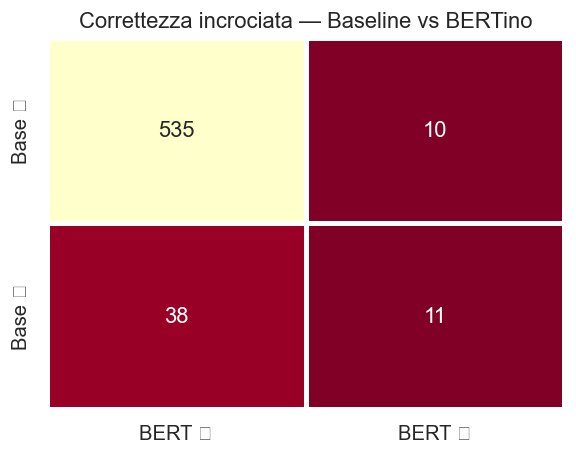

In [9]:
# Heatmap: correttezza incrociata
cross = pd.crosstab(
    test_df["baseline_correct"].map({True: "Base ✓", False: "Base ✗"}),
    test_df["bertino_correct"].map({True: "BERT ✓", False: "BERT ✗"}),
)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cross, annot=True, fmt="d", cmap="YlOrRd_r", ax=ax, cbar=False, linewidths=2, linecolor="white"
)
ax.set_title("Correttezza incrociata — Baseline vs BERTino")
ax.set_ylabel("")
ax.set_xlabel("")
fig.tight_layout()
plt.savefig("../results/plots/cross_correctness.png", dpi=150, bbox_inches="tight")
plt.show()

## 2.5 — Lunghezza dei testi mal classificati

Lunghezza media (parole):
  Globale test set:          46.8
  Errori BERTino:            25.9
  Errori Baseline:           23.6
  Corretti BERTino:          47.5


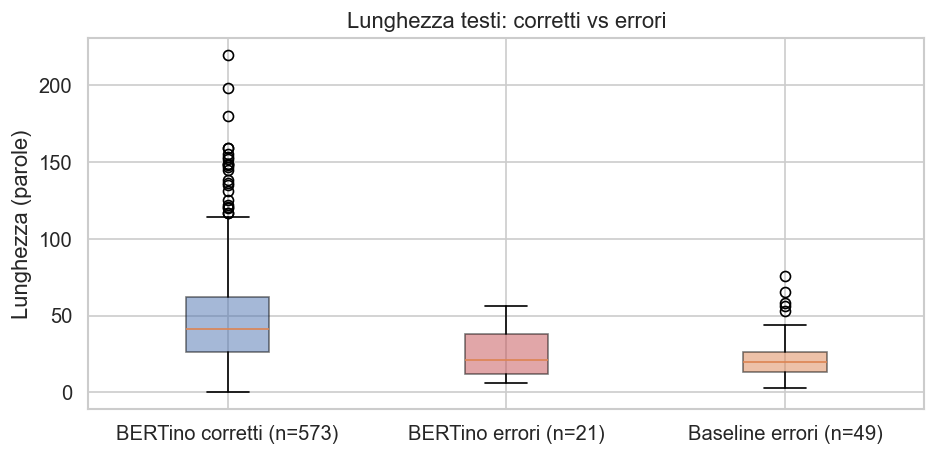

In [10]:
print("Lunghezza media (parole):")
print(f"  Globale test set:          {test_df['text_len_words'].mean():.1f}")
print(f"  Errori BERTino:            {errors_bert['text_len_words'].mean():.1f}")
print(f"  Errori Baseline:           {errors_base['text_len_words'].mean():.1f}")
print(f"  Corretti BERTino:          {correct['text_len_words'].mean():.1f}")

fig, ax = plt.subplots(figsize=(8, 4))
data_to_plot = [
    correct["text_len_words"].values,
    errors_bert["text_len_words"].values,
    errors_base["text_len_words"].values,
]
labels_to_plot = [
    f"BERTino corretti (n={len(correct)})",
    f"BERTino errori (n={len(errors_bert)})",
    f"Baseline errori (n={len(errors_base)})",
]
bp = ax.boxplot(
    data_to_plot,
    labels=labels_to_plot,
    patch_artist=True,
    boxprops=dict(facecolor="#4C72B0", alpha=0.5),
)
bp["boxes"][1].set_facecolor("#C44E52")
bp["boxes"][2].set_facecolor("#DD8452")
ax.set_ylabel("Lunghezza (parole)")
ax.set_title("Lunghezza testi: corretti vs errori")
fig.tight_layout()
plt.savefig("../results/plots/error_length_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 2.6 — Training Dynamics

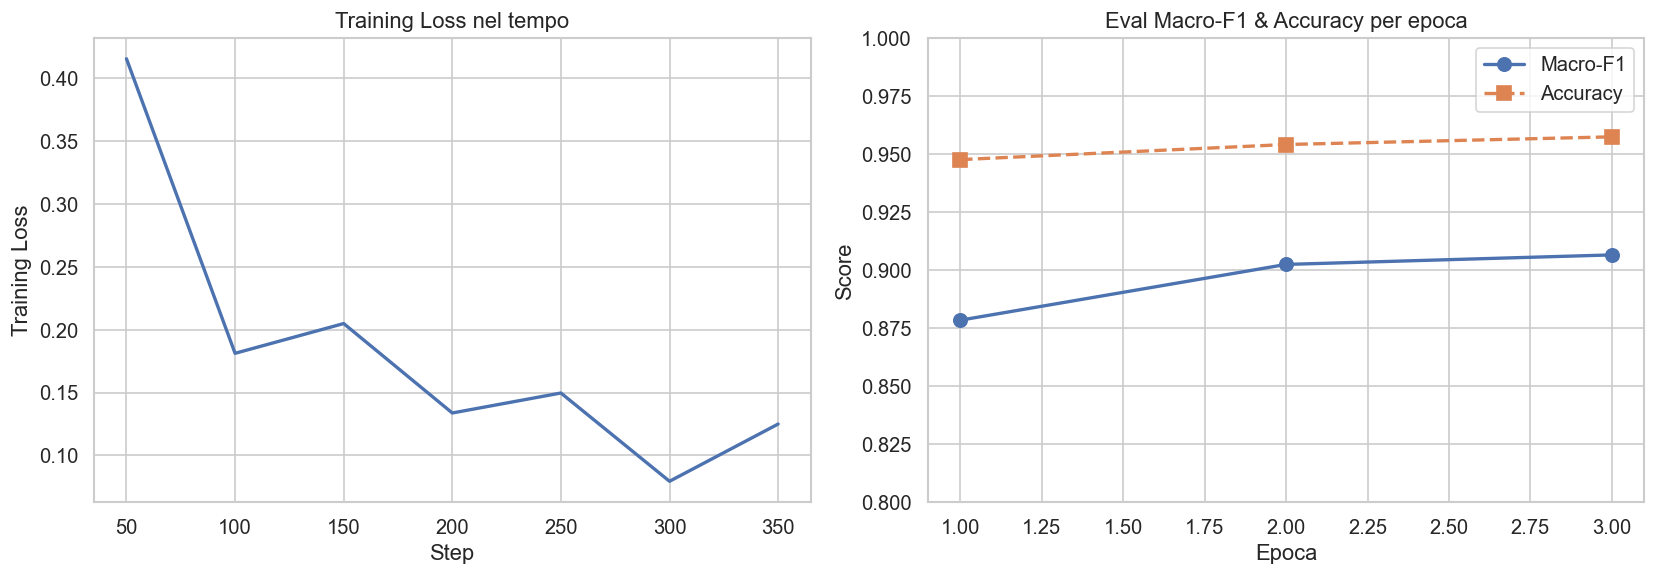

Log entries: 11

Macro-F1 per epoca: ['0.8784', '0.9024', '0.9065']


In [14]:
# Carica training history (se disponibile)
history_path = RESULTS_DIR / "metrics" / "bertino_training_history.json"

if history_path.exists():
    with open(history_path) as f:
        history = json.load(f)["log_history"]

    # Separa training logs (con 'loss') e eval logs (con 'eval_loss')
    train_logs = [h for h in history if "loss" in h and "eval_loss" not in h]
    eval_logs = [h for h in history if "eval_macro_f1" in h]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training loss
    if train_logs:
        steps = [h["step"] for h in train_logs]
        losses = [h["loss"] for h in train_logs]
        axes[0].plot(steps, losses, color="#4C72B0", linewidth=2)
        axes[0].set_xlabel("Step")
        axes[0].set_ylabel("Training Loss")
        axes[0].set_title("Training Loss nel tempo")

    # Eval Macro-F1 per epoca
    if eval_logs:
        epochs = [h.get("epoch", i + 1) for i, h in enumerate(eval_logs)]
        f1s = [h["eval_macro_f1"] for h in eval_logs]
        accs = [h.get("eval_accuracy", 0) for h in eval_logs]

        axes[1].plot(
            epochs, f1s, "o-", color="#4C72B0", linewidth=2, markersize=8, label="Macro-F1"
        )
        axes[1].plot(
            epochs, accs, "s--", color="#DD8452", linewidth=2, markersize=8, label="Accuracy"
        )
        axes[1].set_xlabel("Epoca")
        axes[1].set_ylabel("Score")
        axes[1].set_title("Eval Macro-F1 & Accuracy per epoca")
        axes[1].legend()
        axes[1].set_ylim(0.8, 1.0)

    fig.tight_layout()
    plt.savefig("../results/plots/training_dynamics.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("Log entries:", len(history))
    if eval_logs:
        print(f"\nMacro-F1 per epoca: {[f'{f:.4f}' for f in f1s]}")
else:
    print(f"⚠ Training history non trovata in {history_path}")
    print(
        "  Riesegui train_bert.py per generarla (la versione aggiornata la salva automaticamente)."
    )

## 2.7 — Mini Ablation Study

Confronto dei risultati con diverse configurazioni.

In [12]:
# Ablation 1: Effetto degli n-grammi sulla baseline TF-IDF + LR
from amelia_experiment.baseline import train_tfidf_lr
from amelia_experiment.dataset import load_amelia
from amelia_experiment.metrics import classification_dict
from amelia_experiment.preprocess import encode_label, normalize_text

train_ds = load_amelia(split="train")
val_ds = load_amelia(split="validation")
test_ds = load_amelia(split="test")

# Prepara test labels
test_texts = [normalize_text(t) for t in test_ds["Text"]]
test_labels = [encode_label(lab) for lab in test_ds["Component"]]

ablation_results = []

for ngram in [(1, 1), (1, 2), (1, 3), (2, 2)]:
    for max_feat in [10_000, 50_000]:
        result = train_tfidf_lr(
            train_ds,
            val_ds,
            ngram_range=ngram,
            max_features=max_feat,
        )
        # Valuta su test
        pipeline = result["pipeline"]
        test_preds = pipeline.predict(test_texts).tolist()
        test_metrics = classification_dict(test_labels, test_preds)

        ablation_results.append(
            {
                "ngram_range": str(ngram),
                "max_features": max_feat,
                "val_macro_f1": result["val_metrics"]["macro_f1"],
                "test_macro_f1": test_metrics["macro_f1"],
                "test_accuracy": test_metrics["accuracy"],
            }
        )
        print(
            f"  ngram={ngram}, max_feat={max_feat:>6d} → "
            f"val F1={result['val_metrics']['macro_f1']:.4f}, "
            f"test F1={test_metrics['macro_f1']:.4f}"
        )

ablation_df = pd.DataFrame(ablation_results)
print("\n=== Tabella Ablation Baseline ===")
print(ablation_df.to_string(index=False))

Campo 'license' vuoto nei metadati del builder. Verifica manualmente la licenza su https://huggingface.co/datasets/nlp-unibo/AMELIA
Campo 'license' vuoto nei metadati del builder. Verifica manualmente la licenza su https://huggingface.co/datasets/nlp-unibo/AMELIA
Campo 'license' vuoto nei metadati del builder. Verifica manualmente la licenza su https://huggingface.co/datasets/nlp-unibo/AMELIA


  ngram=(1, 1), max_feat= 10000 → val F1=0.8056, test F1=0.7626
  ngram=(1, 1), max_feat= 50000 → val F1=0.8056, test F1=0.7626
  ngram=(1, 2), max_feat= 10000 → val F1=0.7748, test F1=0.7484
  ngram=(1, 2), max_feat= 50000 → val F1=0.7647, test F1=0.7484
  ngram=(1, 3), max_feat= 10000 → val F1=0.7811, test F1=0.7556
  ngram=(1, 3), max_feat= 50000 → val F1=0.7647, test F1=0.7260
  ngram=(2, 2), max_feat= 10000 → val F1=0.5984, test F1=0.6033
  ngram=(2, 2), max_feat= 50000 → val F1=0.5984, test F1=0.6033

=== Tabella Ablation Baseline ===
ngram_range  max_features  val_macro_f1  test_macro_f1  test_accuracy
     (1, 1)         10000      0.805569       0.762624       0.920875
     (1, 1)         50000      0.805569       0.762624       0.920875
     (1, 2)         10000      0.774792       0.748364       0.917508
     (1, 2)         50000      0.764744       0.748364       0.917508
     (1, 3)         10000      0.781138       0.755556       0.919192
     (1, 3)         50000      0.

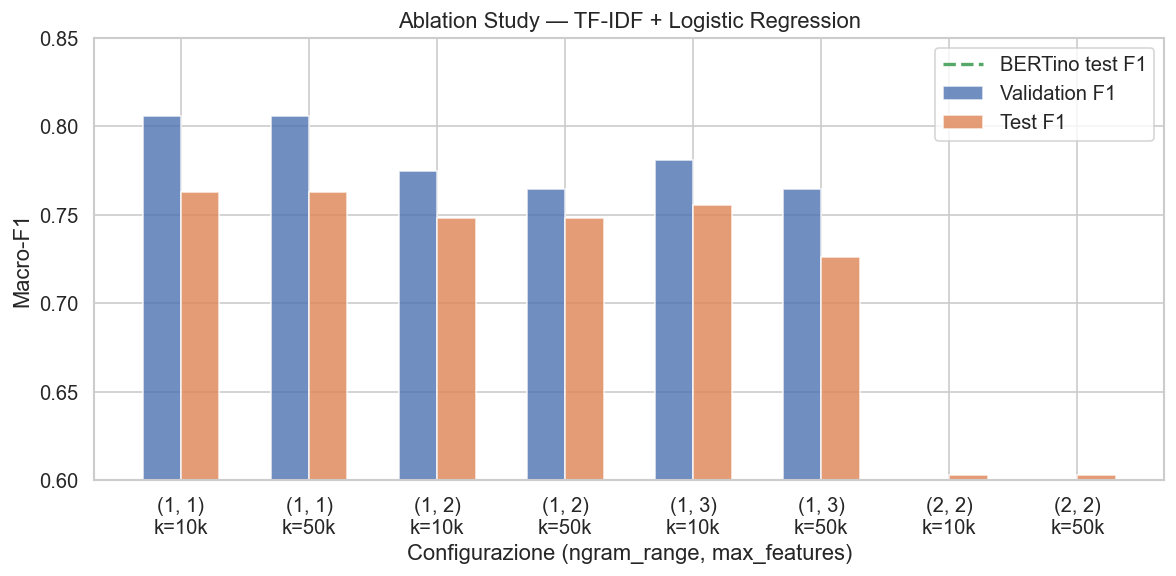


Miglior baseline: ngram=(1, 1), max_features=10000
  Test Macro-F1: 0.7626
  Gap con BERTino: 0.1595


In [13]:
# Visualizzazione ablation
fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(ablation_df))
labels = [f"{r['ngram_range']}\nk={r['max_features'] // 1000}k" for _, r in ablation_df.iterrows()]

bars_val = ax.bar(
    [i - 0.15 for i in x],
    ablation_df["val_macro_f1"],
    0.3,
    label="Validation F1",
    color="#4C72B0",
    alpha=0.8,
)
bars_test = ax.bar(
    [i + 0.15 for i in x],
    ablation_df["test_macro_f1"],
    0.3,
    label="Test F1",
    color="#DD8452",
    alpha=0.8,
)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Configurazione (ngram_range, max_features)")
ax.set_ylabel("Macro-F1")
ax.set_title("Ablation Study — TF-IDF + Logistic Regression")
ax.legend()
ax.set_ylim(0.6, 0.85)

# Linea BERTino come riferimento
ax.axhline(y=0.9221, color="#55A868", linestyle="--", linewidth=2, label="BERTino test F1")
ax.legend()

fig.tight_layout()
plt.savefig("../results/plots/ablation_baseline.png", dpi=150, bbox_inches="tight")
plt.show()

# Miglior configurazione baseline
best = ablation_df.loc[ablation_df["test_macro_f1"].idxmax()]
print(f"\nMiglior baseline: ngram={best['ngram_range']}, max_features={int(best['max_features'])}")
print(f"  Test Macro-F1: {best['test_macro_f1']:.4f}")
print(f"  Gap con BERTino: {0.9221 - best['test_macro_f1']:.4f}")

## 2.8 — Riepilogo Error Analysis

**Conclusioni chiave:**

1. **Errori di BERTino:** pochi e con confidence inferiore alla media → il modello è ben calibrato
2. **Errori in comune con la baseline:** sono i campioni intrinsecamente più ambigui del dataset
3. **BERTino corregge molti errori della baseline,** dimostrando che le rappresentazioni contestuali catturano segnali che BoW non vede
4. **Training dynamics:** la loss decresce regolarmente, il Macro-F1 si stabilizza dopo la 2ª epoca — 3 epoche sono un buon compromesso
5. **Ablation baseline:** la configurazione (1,2) con 50k features è tra le migliori, ma nessuna variante si avvicina a BERTino